In [1]:
import numpy as np
import pandas as pd
from utils.parallel import parallel_analysis_multiprocessing
from utils.parallel import parallel_analysis_threading
from utils.statistics import calculate_moving_average_city
from utils.statistics import detect_anomalies
from utils.statistics import plot_long_term_trends
from utils.statistics import seasonal_statistics

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/temperature_data.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   city         54750 non-null  object        
 1   timestamp    54750 non-null  datetime64[ns]
 2   temperature  54750 non-null  float64       
 3   season       54750 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.7+ MB


In [4]:
%time pd.concat([calculate_moving_average_city(group) for _, group in data.groupby('city')])
%time parallel_analysis_multiprocessing(data, calculate_moving_average_city)
%time parallel_analysis_threading(data, calculate_moving_average_city)

CPU times: user 6.55 ms, sys: 1.36 ms, total: 7.91 ms
Wall time: 6.95 ms
CPU times: user 17.4 ms, sys: 24.6 ms, total: 42 ms
Wall time: 1.43 s
CPU times: user 7.14 ms, sys: 2.09 ms, total: 9.22 ms
Wall time: 8.3 ms


,city,timestamp,temperature,season,rolling_mean
25550,Beijing,2010-01-01,-2.260955,winter,NaN
25551,Beijing,2010-01-02,-10.558666,winter,NaN
25552,Beijing,2010-01-03,-10.551934,winter,NaN
25553,Beijing,2010-01-04,0.731011,winter,NaN
25554,Beijing,2010-01-05,-12.455813,winter,NaN
...,...,...,...,...,...
14595,Tokyo,2019-12-25,9.571640,winter,8.842554
14596,Tokyo,2019-12-26,8.837476,winter,8.465830
14597,Tokyo,2019-12-27,11.440133,winter,8.253018
14598,Tokyo,2019-12-28,7.212861,winter,7.757297


In [5]:
%time seasonal_statistics(data)
%time parallel_analysis_multiprocessing(data, seasonal_statistics)
%time parallel_analysis_threading(data, seasonal_statistics)

CPU times: user 5.79 ms, sys: 1.49 ms, total: 7.28 ms
Wall time: 6.29 ms
CPU times: user 10.5 ms, sys: 14 ms, total: 24.5 ms
Wall time: 1.17 s
CPU times: user 29.8 ms, sys: 6.53 ms, total: 36.3 ms
Wall time: 30.2 ms


,city,season,mean_temp,std_temp
0,Beijing,autumn,16.188882,5.049858
1,Beijing,spring,12.949303,5.049212
2,Beijing,summer,26.998574,4.972529
3,Beijing,winter,-2.296238,5.117812
0,Berlin,autumn,10.945528,4.788374
1,Berlin,spring,10.357663,4.895491
2,Berlin,summer,19.597776,4.945771
3,Berlin,winter,0.180727,5.082050
0,Cairo,autumn,24.863957,5.124046
1,Cairo,spring,24.796030,4.892322


In [8]:
def detect_anomalies(data, stats):
    anomalies = []
    for _, row in stats.iterrows():
        city_season_data = data[
            (data["city"] == row["city"]) & (data["season"] == row["season"])
        ]
        mean, std = row["mean_temp"], row["std_temp"]
        outliers = city_season_data[
            (city_season_data["temperature"] < mean - 2 * std)
            | (city_season_data["temperature"] > mean + 2 * std)
        ]
        anomalies.append(outliers)
    return pd.concat(anomalies)


anomalies = detect_anomalies(data, seasonal_stats)

In [9]:
anomalies.head()

,city,timestamp,temperature,season
25818,Beijing,2010-09-26,-5.040858,autumn
25826,Beijing,2010-10-04,27.660868,autumn
25831,Beijing,2010-10-09,4.937189,autumn
25833,Beijing,2010-10-11,4.670519,autumn
25839,Beijing,2010-10-17,5.369238,autumn


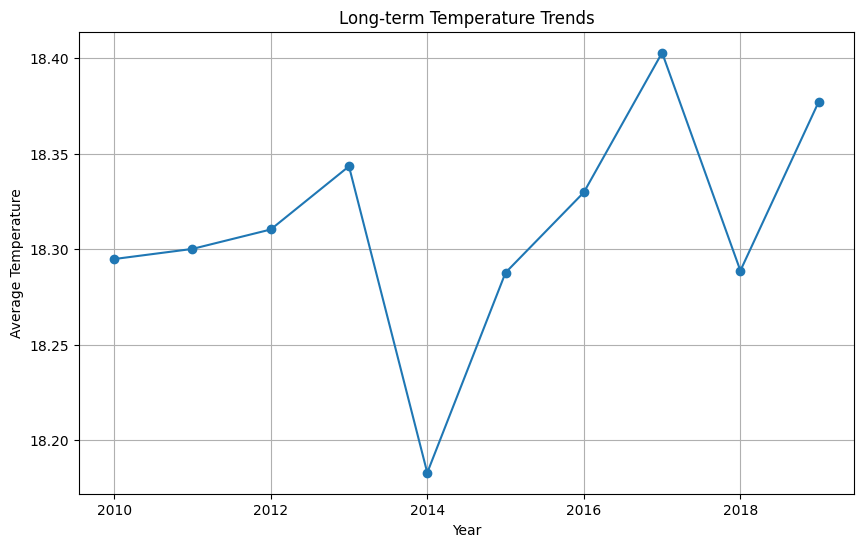

In [10]:
def plot_long_term_trends(data):
    trends = data.groupby("year")["temperature"].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(trends.index, trends.values, marker="o")
    plt.title("Long-term Temperature Trends")
    plt.xlabel("Year")
    plt.ylabel("Average Temperature")
    plt.grid()
    plt.show()


data["year"] = data["timestamp"].dt.year
plot_long_term_trends(data)

In [11]:
def parallel_analysis_multiprocessing(data, n_processes=4):
    chunks = np.array_split(data["city"].unique(), n_processes)
    with Pool(n_processes) as pool:
        results = pool.map(
            calculate_moving_average_city,
            [data[data["city"].isin(chunk)] for chunk in chunks],
        )
    return pd.concat(results)

In [12]:
def parallel_analysis_threading(data, n_threads=4):
    chunks = np.array_split(data["city"].unique(), n_threads)
    results = []

    def worker(chunk):
        results.append(func(chunk))

    thread_list = [
        Thread(target=worker, args=(data[data["city"].isin(chunk)],))
        for chunk in chunks
    ]

    for thread in thread_list:
        thread.start()

    for thread in thread_list:
        thread.join()

    return pd.concat(results)

In [13]:
def process_chunk(cities, data, func):
    filtered_data = data[data["city"].isin(cities)]
    return func(filtered_data)

In [ ]:
from multiprocessing import Pool, cpu_count
import pandas as pd

if __name__ == "__main__":
    # Определяем функцию на верхнем уровне модуля
    def calculate_moving_average_city(city_data: pd.DataFrame) -> pd.DataFrame:
        city_data["rolling_mean"] = city_data["temperature"].rolling(window=30).mean()
        return city_data

    def calculate_moving_average_multiprocessing(df: pd.DataFrame) -> pd.DataFrame:
        # Разделяем данные по городам
        city_groups = [group for _, group in df.groupby("city")]

        # Количество процессов равно количеству ядер процессора
        with Pool(cpu_count()) as pool:
            results = pool.map(calculate_moving_average_city, city_groups)

        # Объединяем результаты
        return pd.concat(results)

    # Загружаем данные для тестирования
    data = pd.read_csv("data/temperature_data.csv")
    data["timestamp"] = pd.to_datetime(data["timestamp"])

    # Пример вызова функции
    result = calculate_moving_average_multiprocessing(data)
    print(result.head())

Process SpawnPoolWorker-9:
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-11:
Process SpawnPoolWorker-12:
Process SpawnPoolWorker-13:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", line 369, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
Traceback (most recent call last):
AttributeError: Can't get attribute 'calculate_moving_average_city' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>

In [ ]:
parallel_analysis_multiprocessing(data, calculate_moving_average_city).dropna()